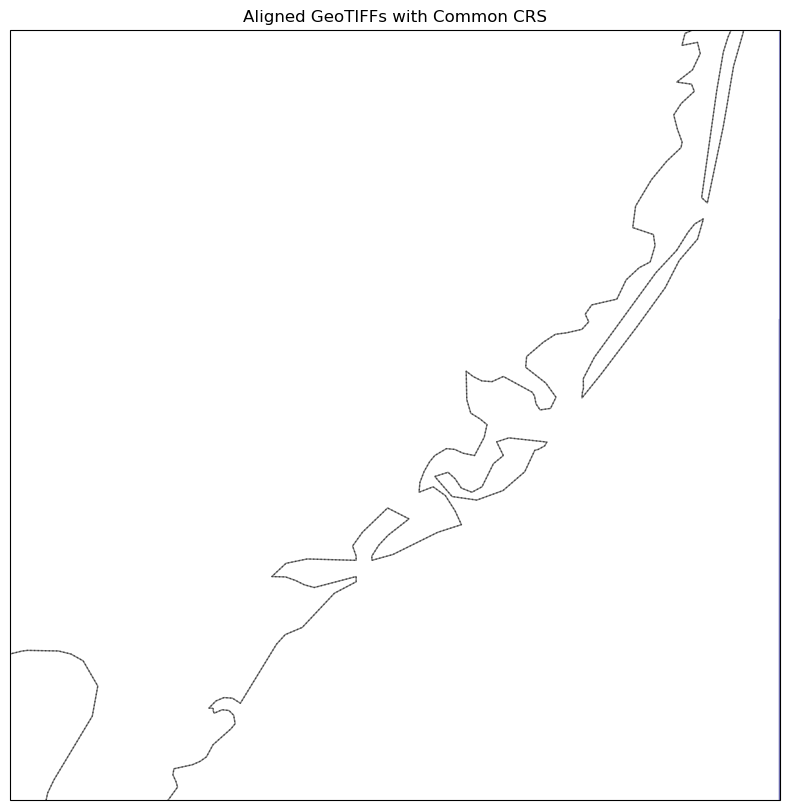

In [8]:
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

with rasterio.open("../geotiffs/USGS_1_n40w075_20210624.tif") as src:
    min_x = min(min_x, src.bounds.left)
    max_x = max(max_x, src.bounds.right)
    min_y = min(min_y, src.bounds.bottom)
    max_y = max(max_y, src.bounds.top)

# Plot the reprojected GeoTIFFs with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add base map features
ax.add_feature(cfeature.BORDERS, linestyle="--", alpha=0.5)
ax.add_feature(cfeature.COASTLINE, alpha=0.5)
ax.add_feature(cfeature.STATES, linestyle=":", alpha=0.5)

# Set the extent
ax.set_extent([min_x, max_x, min_y, max_y], crs=ccrs.PlateCarree())

# Overlay the GeoTIFFs
with rasterio.open("../geotiffs/USGS_1_n40w075_20210624.tif") as src:
    data = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
    ax.imshow(data, transform=ccrs.PlateCarree(), extent=extent, origin='upper', 
              cmap='terrain', alpha=0.7)

# Add title and display/save
plt.title("Aligned GeoTIFFs with Common CRS")
plt.savefig("../geotiffs/aligned_geotiffs.png", dpi=300, bbox_inches="tight")
plt.show()


In [12]:
import rasterio
from rasterio.merge import merge
import numpy as np
import glob

# List of raster files
raster_files = glob.glob("../geotiffs/*.tif")

# Open raster files
src_files_to_mosaic = [rasterio.open(f) for f in raster_files]

# Check the NoData value from the first file (assuming all tiles have the same NoData)
nodata_value = src_files_to_mosaic[0].nodata

# Merge rasters into a mosaic, passing the NoData value
mosaic, out_transform = merge(src_files_to_mosaic, nodata=nodata_value)

# Update metadata for the mosaic
out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform,
    "crs": src_files_to_mosaic[0].crs,
    "nodata": nodata_value,  # Ensure NoData is preserved in output
})

# Save the mosaic to a file
mosaic_path = "../geotiffs/mosaic_full.tif"
with rasterio.open(mosaic_path, "w", **out_meta) as dest:
    dest.write(mosaic)

# Close source files
for src in src_files_to_mosaic:
    src.close()

print("Mosaic created successfully.")


Mosaic created successfully.


In [13]:
import rasterio

# Open the raster file
with rasterio.open("../geotiffs/USGS_1_n40w075_20210624.tif") as src:
    # Get the NoData value from the raster
    nodata_value = src.nodata
    print(f"NoData value: {nodata_value}")

    # Read the data
    data = src.read(1)  # Reading the first band

    # Check the min/max values
    print(f"Data Min: {data.min()}, Data Max: {data.max()}")


NoData value: -999999.0
Data Min: -999999.0, Data Max: 66.1990737915039


In [14]:
import rasterio

# Open the raster file
with rasterio.open("../geotiffs/mosaic_full.tif") as src:
    # Get the NoData value from the raster
    nodata_value = src.nodata
    print(f"NoData value: {nodata_value}")

    # Read the data
    data = src.read(1)  # Reading the first band

    # Check the min/max values
    print(f"Data Min: {data.min()}, Data Max: {data.max()}")


NoData value: -999999.0
Data Min: nan, Data Max: nan


In [15]:
from osgeo import gdal

# Input and output file paths
input_file = "../geotiffs/mosaic_full.tif"
output_file = "../geotiffs/mosaic_downsampled.tif"

# Open the input file
src = gdal.Open(input_file)

# Calculate the new resolution (e.g., downsample by 2x)
x_res = src.RasterXSize / 2  # Adjust divisor for less/more downsampling
y_res = src.RasterYSize / 2

# Perform the downsampling
gdal.Translate(
    output_file,
    src,
    width=int(x_res),
    height=int(y_res),
    resampleAlg="bilinear",  # Bilinear resampling for smoother results
)

print(f"Downsampled mosaic saved to {output_file}")

/storage/group/ibb3/default/.conda/envs/mapping/lib/python3.13/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Downsampled mosaic saved to ../geotiffs/mosaic_downsampled.tif


In [17]:
import numpy as np
import rasterio

with rasterio.open("../geotiffs/mosaic_downsampled.tif") as src:
    data = src.read(1)
    
    # Check the values directly
    print(f"Unique values in the data: {np.unique(data)}")
    print(f"Min/Max of data: {np.nanmin(data)} / {np.nanmax(data)}")
    print(f"NaN values count: {np.sum(np.isnan(data))}")


Unique values in the data: [-9.9999900e+05 -9.3380081e+01 -9.1333069e+01 ...  1.9088226e+03
  1.9107296e+03            nan]
Min/Max of data: -999999.0 / 1910.7296142578125
NaN values count: 8


In [18]:
import numpy as np
import rasterio

with rasterio.open("../geotiffs/mosaic_full.tif") as src:
    data = src.read(1)
    
    # Check the values directly
    print(f"Unique values in the data: {np.unique(data)}")
    print(f"Min/Max of data: {np.nanmin(data)} / {np.nanmax(data)}")
    print(f"NaN values count: {np.sum(np.isnan(data))}")


Unique values in the data: [-9.9999900e+05 -9.6714943e+01 -9.6257019e+01 ...  1.9126271e+03
  1.9137310e+03            nan]
Min/Max of data: -999999.0 / 1913.73095703125
NaN values count: 7


In [21]:
import rasterio
import numpy as np

# Open the raster file
with rasterio.open("../geotiffs/mosaic_full.tif", "r+") as src:
    # Read the first band (assuming a single-band raster)
    data = src.read(1)

    # Get the NoData value
    nodata_value = src.nodata
    if nodata_value is None:
        # If NoData is not set, assign a custom value, e.g., -9999
        nodata_value = -9999
        print(f"NoData value is not set. Using {nodata_value} as NoData.")
    
    # Replace NaN values with NoData value
    data = np.nan_to_num(data, nan=nodata_value)

    # Write the updated data back to the raster
    src.write(data, 1)

    print(f"Replaced NaN values with NoData value: {nodata_value}")


Replaced NaN values with NoData value: -999999.0


In [22]:
import numpy as np
import rasterio

with rasterio.open("../geotiffs/mosaic_full.tif") as src:
    data = src.read(1)
    
    # Check the values directly
    print(f"Unique values in the data: {np.unique(data)}")
    print(f"Min/Max of data: {np.nanmin(data)} / {np.nanmax(data)}")
    print(f"NaN values count: {np.sum(np.isnan(data))}")


Unique values in the data: [-9.9999900e+05 -9.6714943e+01 -9.6257019e+01 ...  1.9121781e+03
  1.9126271e+03  1.9137310e+03]
Min/Max of data: -999999.0 / 1913.73095703125
NaN values count: 0


In [23]:
import rasterio
import numpy as np

# Open the raster file
with rasterio.open("../geotiffs/mosaic_downsampled.tif", "r+") as src:
    # Read the first band (assuming a single-band raster)
    data = src.read(1)

    # Get the NoData value
    nodata_value = src.nodata
    if nodata_value is None:
        # If NoData is not set, assign a custom value, e.g., -9999
        nodata_value = -9999
        print(f"NoData value is not set. Using {nodata_value} as NoData.")
    
    # Replace NaN values with NoData value
    data = np.nan_to_num(data, nan=nodata_value)

    # Write the updated data back to the raster
    src.write(data, 1)

    print(f"Replaced NaN values with NoData value: {nodata_value}")


Replaced NaN values with NoData value: -999999.0


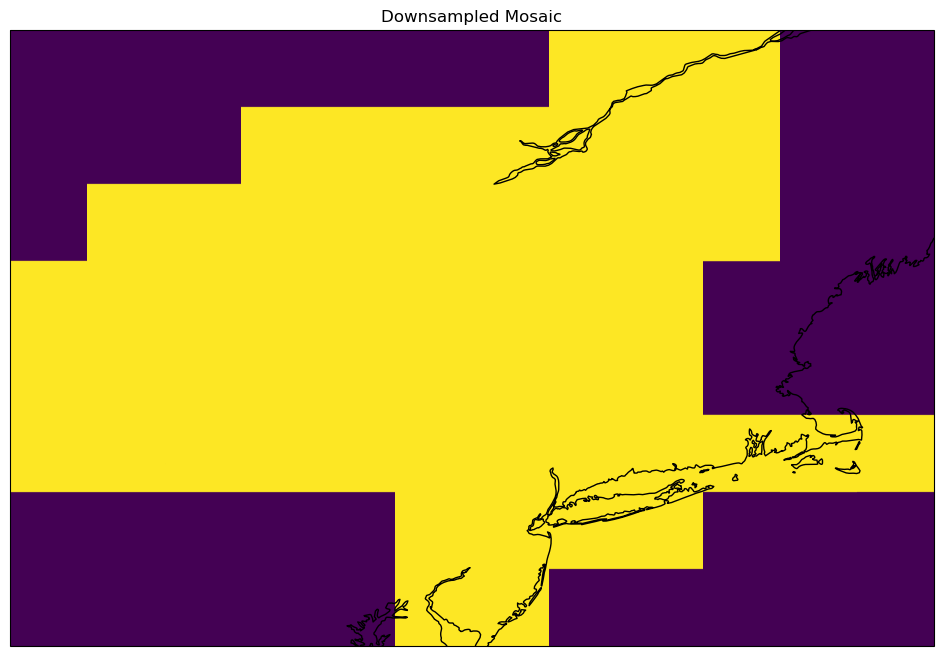

In [25]:
import matplotlib.pyplot as plt
import rasterio
import cartopy.crs as ccrs

# Open the downsampled raster
with rasterio.open("../geotiffs/mosaic_downsampled.tif") as src:
    data = src.read(1)
    extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)

# Plot with Cartopy
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.PlateCarree()},
    figsize=(12, 8)
)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.imshow(
    data,
    extent=extent,
    transform=ccrs.PlateCarree(),
    cmap="viridis",
    origin="upper"
)
ax.coastlines()
plt.title("Downsampled Mosaic")
plt.savefig("../geotiffs/test.png", dpi = 300)
plt.show()

In [ ]:
import os
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.merge import merge
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Directory containing GeoTIFF files
geo_tiff_dir = "../geotiffs/processed"
processed_dir = "../geotiffs/reprocessed/"
os.makedirs(processed_dir, exist_ok=True)

# Target CRS (e.g., EPSG:4326 for WGS84)
target_crs = "EPSG:4326"

# Function to reproject GeoTIFFs to a common CRS
def reproject_tiff(input_tiff, output_tiff, target_crs):
    with rasterio.open(input_tiff) as src:
        transform, width, height = calculate_default_transform(
            src.crs, target_crs, src.width, src.height, *src.bounds
        )
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_tiff, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.bilinear  # Bilinear resampling for continuous data
                )

# Reproject all GeoTIFFs
reprojected_files = []
for geo_tiff in os.listdir(geo_tiff_dir):
    if geo_tiff.endswith(".tif"):
        input_tiff = os.path.join(geo_tiff_dir, geo_tiff)
        output_tiff = os.path.join(processed_dir, f"reprojected_{geo_tiff}")
        reproject_tiff(input_tiff, output_tiff, target_crs)
        reprojected_files.append(output_tiff)

# Calculate maximum extent across reprojected GeoTIFFs
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

for reprojected_tiff in reprojected_files:
    with rasterio.open(reprojected_tiff) as src:
        min_x = min(min_x, src.bounds.left)
        max_x = max(max_x, src.bounds.right)
        min_y = min(min_y, src.bounds.bottom)
        max_y = max(max_y, src.bounds.top)

# Plot the reprojected GeoTIFFs with Cartopy
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add base map features
ax.add_feature(cfeature.BORDERS, linestyle="--", alpha=0.5)
ax.add_feature(cfeature.COASTLINE, alpha=0.5)
ax.add_feature(cfeature.STATES, linestyle=":", alpha=0.5)

# Set the extent
ax.set_extent([min_x, max_x, min_y, max_y], crs=ccrs.PlateCarree())

# Overlay the GeoTIFFs
for reprojected_tiff in reprojected_files:
    with rasterio.open(reprojected_tiff) as src:
        data = src.read(1)
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        ax.imshow(data, transform=ccrs.PlateCarree(), extent=extent, origin='upper', cmap='terrain', alpha=0.7)

# Add title and display/save
plt.title("Aligned GeoTIFFs with Common CRS")
plt.savefig("../geotiffs/aligned_geotiffs.png", dpi=300, bbox_inches="tight")
plt.show()


In [9]:
!mkdir -p ../geotiffs/test_files

In [11]:
!cp ../geotiffs/mosaic_downsampled.tif ../geotiffs/test_files/

In [14]:
!ls -lh ../geotiffs/

total 8.1G
-rw-rw-r-- 1 nsl5160 ibb3_collab  38M Dec  3  2022 USGS_1_n40w075_20210624.tif
-rw-rw-r-- 1 nsl5160 ibb3_collab  55M May 24  2022 USGS_1_n40w076_20220524.tif
-rw-rw-r-- 1 nsl5160 ibb3_collab 7.9M Dec  3  2022 USGS_1_n41w073_20151214.tif
-rw-rw-r-- 1 nsl5160 ibb3_collab  20M Sep 26 16:05 USGS_1_n41w074_20240925.tif
-rw-rw-r-- 1 nsl5160 ibb3_collab  58M Nov 15  2022 USGS_1_n41w075_20221115.tif
-rw-rw-r-- 1 nsl5160 ibb3_collab  57M Nov 15  2022 USGS_1_n41w076_20221115.tif
-rw-rw-r-- 1 nsl5160 ibb3_collab 1.8M Jan 17  2023 USGS_1_n42w070_20230117.tif
-rw-rw-r-- 1 nsl5160 ibb3_collab  21M Jan 17  2023 USGS_1_n42w071_20230117.tif
-rw-rw-r-- 1 nsl5160 ibb3_collab  36M Jan 30  2024 USGS_1_n42w072_20240130.tif
-rw-rw-r-- 1 nsl5160 ibb3_collab  46M Dec  3  2022 USGS_1_n42w073_20211109.tif
-rw-rw-r-- 1 nsl5160 ibb3_collab  54M Oct 10 18:06 USGS_1_n42w074_20241010.tif
-rw-rw-r-- 1 nsl5160 ibb3_collab  55M Sep 26 16:04 USGS_1_n42w075_20240925.tif
-rw-rw-r-- 1 nsl5160 ibb3_collab  54M Feb

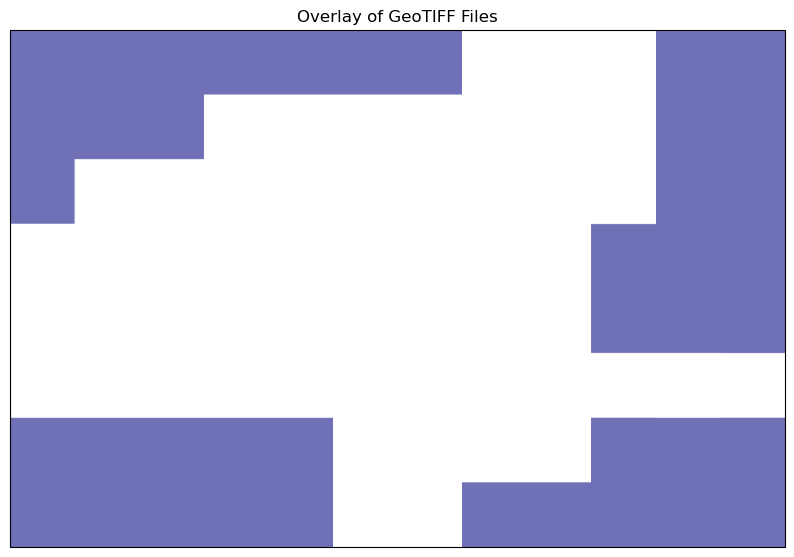

In [13]:
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Directory containing GeoTIFF files
geo_tiff_dir = "../geotiffs/test_files"


# Iterate through all files in the directory
geo_tiff_files = [os.path.join(geo_tiff_dir, f) for f in os.listdir(geo_tiff_dir) if f.endswith(".tif")]

# Initialize variables to track the maximum extent
min_x, min_y = float('inf'), float('inf')
max_x, max_y = float('-inf'), float('-inf')

# First pass: Compute the maximum extent across all GeoTIFFs
for geo_tiff in geo_tiff_files:
    with rasterio.open(geo_tiff) as src:
        # Update the bounds
        min_x = min(min_x, src.bounds.left)
        max_x = max(max_x, src.bounds.right)
        min_y = min(min_y, src.bounds.bottom)
        max_y = max(max_y, src.bounds.top)

# Create a Cartopy plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Add base map features
#ax.add_feature(cfeature.BORDERS, linestyle="--", alpha=0.5)
#ax.add_feature(cfeature.COASTLINE, alpha=0.5)
#ax.add_feature(cfeature.STATES, linestyle=":", alpha=0.5)

# Set the computed maximum extent
ax.set_extent([min_x, max_x, min_y, max_y], crs=ccrs.PlateCarree())

# Second pass: Plot all GeoTIFFs
for geo_tiff in geo_tiff_files:
    with rasterio.open(geo_tiff) as src:
        # Read the first band
        data = src.read(1)
        # Get the extent of the GeoTIFF
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        # Plot the GeoTIFF
        ax.imshow(data, transform=ccrs.PlateCarree(), extent=extent, origin='upper', cmap='terrain', alpha=0.7)

# Add title
plt.title("Overlay of GeoTIFF Files")
plt.savefig("../geotiffs/test.png", dpi = 300, bbox_inches='tight')
plt.show()

In [6]:
import rasterio
from skimage.exposure import match_histograms
import numpy as np
import glob

# Reference tile for brightness/color matching
reference_tile_path = "../geotiffs/USGS_1_n40w075_20210624.tif"

# Open the reference tile
with rasterio.open(reference_tile_path) as ref_src:
    reference_tile = ref_src.read(1)

# List of raster tiles
raster_files = glob.glob("../geotiffs/*.tif")

# Directory to save processed tiles
processed_dir = "../geotiffs/processed/"

# Process each tile
for raster_file in raster_files:
    with rasterio.open(raster_file) as src:
        # Read the tile data
        tile = src.read(1)
        profile = src.profile

        # Match histogram to the reference tile
        matched_tile = match_histograms(tile, reference_tile)

        # Save the processed tile
        processed_path = f"{processed_dir}/{raster_file.split('/')[-1]}"
        with rasterio.open(processed_path, "w", **profile) as dst:
            dst.write(matched_tile.astype(profile["dtype"]), 1)

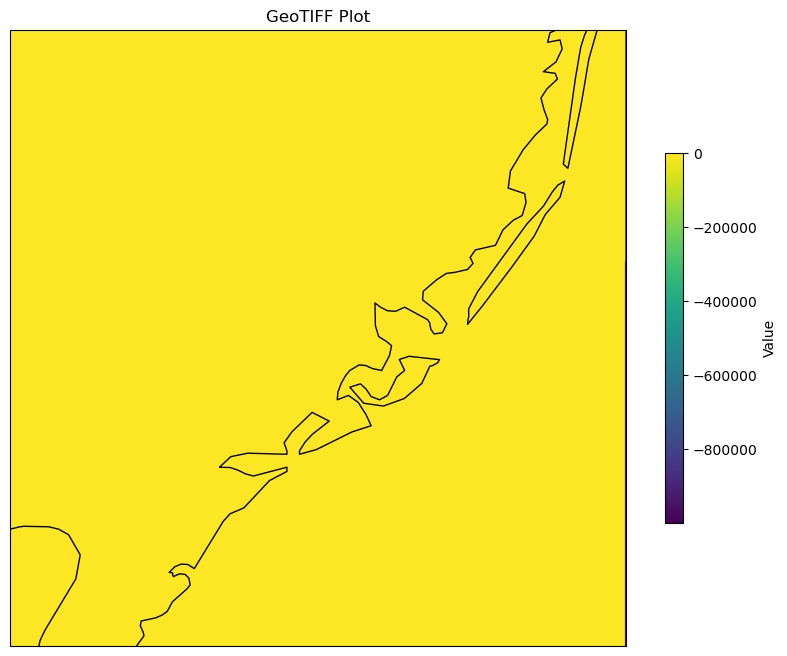

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import rasterio
from rasterio.plot import show

# File path to your GeoTIFF
file_path = "../geotiffs/USGS_1_n40w075_20210624.tif"

# Open the GeoTIFF using rasterio
with rasterio.open(file_path) as src:
    # Read the data and its transform
    data = src.read(1)  # Reading the first band
    transform = src.transform

    # Get the extent of the GeoTIFF
    extent = (
        transform[2],
        transform[2] + transform[0] * src.width,
        transform[5] + transform[4] * src.height,
        transform[5],
    )

# Plotting with Cartopy
fig, ax = plt.subplots(
    subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(10, 8)
)
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add the GeoTIFF data
img = ax.imshow(
    data,
    origin="upper",
    extent=extent,
    transform=ccrs.PlateCarree(),
    cmap="viridis",  # Adjust colormap as needed
)

# Add coastlines for context
ax.coastlines()

# Add a colorbar
cbar = plt.colorbar(img, ax=ax, orientation="vertical", shrink=0.6, label="Value")

# Add a title
plt.title("GeoTIFF Plot")

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import re
from Bio import SeqIO
from itertools import combinations

metadata = pd.read_csv("../wilmurt_meta.csv")

strains = ['Assinica (Hatchery)', 'Domestic (Hatchery)',
       'Horn (Hatchery)', 'Little Tupper (Hatchery)', 
           'Temiscamie (Hatchery)', 'Windfall (Hatchery)']
for comb in combinations(strains, 5):
    combo = comb[0][0]+comb[1][0]+comb[2][0]+comb[3][0]+comb[4][0]
    hatchery = (metadata["Novogene_ID"][metadata["Source"].isin(list(comb))]
            [metadata["Source"].str.contains("Hatchery")]
            [~metadata["Novogene_ID"].str.contains("TxD")]).tolist()
    for seq_record in SeqIO.parse("../ingroup_and_outgroup_circularized.msa", "fasta"):
        if str(seq_record.id) in hatchery:
            for i in list(range(len(seq_record.seq) - 450))[0::5]:
                with open("../gene_windows/" + str(i) + "_" + combo + ".fasta","a") as f:
                   f.write(">" + str(seq_record.id) + "\n")
                   f.write(str(seq_record.seq[i:i+450].ungap("-")) + "\n")

/storage/group/ibb3/default/.conda/envs/masters/lib/python3.10/site-packages/Bio/Seq.py:2096: BiopythonDeprecationWarning: myseq.ungap(gap) is deprecated; please use myseq.replace(gap, "") instead.
  warnings.warn(


In [ ]:
%%bash
for i in $( ls ../gene_windows/*_AHL.fasta | sed "s/.fasta//g" ); do
    echo $i
done

In [ ]:
for i in $( ls ../gene_windows/*_AHL.fasta | sed "s/.fasta//g" | cut -d"/" -f3); do
    vsearch --derep_fulllength ../gene_windows/${i}.fasta \
        --output ../gene_windows/${i}.derep.fasta \
        --sizeout --threads 8 \
        --uc ../gene_windows/${i}.derep.uc \
        --fasta_width 0
done

In [ ]:
%%bash
source ~/.bashrc
conda activate ipyrad
for i in $( ls ../gene_windows/*_?????.fasta | sed "s/.fasta//g" | cut -d"/" -f3 ); do
    vsearch --derep_fulllength ../gene_windows/${i}.fasta \
        --output ../gene_windows/${i}.derep.fasta \
        --sizeout --threads 8 \
        --uc ../gene_windows/${i}.derep.uc \
        --fasta_width 0
done